In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/arabic-manuscripts-digitization.zip'
extract_to = '/content/data_folder'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [ ]:
# STEP 1: Install Required Packages
# Run this cell FIRST to install all dependencies

import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ Successfully installed {package}")
    except subprocess.CalledProcessError:
        print(f"✗ Failed to install {package}")

# Essential packages for this challenge
packages = [
    "opencv-python",
    "easyocr",
    "pytesseract",
    "python-Levenshtein",
    "transformers",
    "torch",
    "torchvision",
    "matplotlib",
    "seaborn",
    "pandas",
    "numpy",
    "pillow"
]

print("Installing packages for Arabic Manuscript OCR Challenge...")
for package in packages:
    install_package(package)

print("\n🎉 Installation complete! Now run the next cell to import libraries.")

Installing packages for Arabic Manuscript OCR Challenge...
✓ Successfully installed opencv-python
✓ Successfully installed easyocr
✓ Successfully installed pytesseract
✓ Successfully installed python-Levenshtein
✓ Successfully installed transformers
✓ Successfully installed torch
✓ Successfully installed torchvision
✓ Successfully installed matplotlib
✓ Successfully installed seaborn
✓ Successfully installed pandas
✓ Successfully installed numpy
✓ Successfully installed pillow

🎉 Installation complete! Now run the next cell to import libraries.


In [ ]:
# STEP 2: Import Libraries
!pip install paddleocr paddlepaddle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import os
from pathlib import Path
import torch
import warnings
warnings.filterwarnings('ignore')

# Try importing OCR libraries with error handling
try:
    import easyocr
    print("✓ EasyOCR imported successfully")
    EASYOCR_AVAILABLE = True
except ImportError:
    print("✗ EasyOCR not available - run the installation cell first")
    EASYOCR_AVAILABLE = False

try:
    import pytesseract
    print("✓ Pytesseract imported successfully")
    PYTESSERACT_AVAILABLE = True
except ImportError:
    print("✗ Pytesseract not available - run the installation cell first")
    PYTESSERACT_AVAILABLE = False

try:
    from transformers import TrOCRProcessor, VisionEncoderDecoderModel
    print("✓ Transformers imported successfully")
    TRANSFORMERS_AVAILABLE = True
except ImportError:
    print("✗ Transformers not available - run the installation cell first")
    TRANSFORMERS_AVAILABLE = False

try:
    import Levenshtein
    print("✓ Levenshtein imported successfully")
    LEVENSHTEIN_AVAILABLE = True
except ImportError:
    print("✗ Levenshtein not available - run the installation cell first")
    LEVENSHTEIN_AVAILABLE = False

from difflib import SequenceMatcher

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')

print("Libraries imported successfully!")
print("Available GPU:", "Yes" if torch.cuda.is_available() else "No")


✓ EasyOCR imported successfully
✓ Pytesseract imported successfully
✓ Transformers imported successfully
✓ Levenshtein imported successfully
Libraries imported successfully!
Available GPU: Yes


In [ ]:
# Load the datasets
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

print("Dataset Overview:")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nTraining data columns: {train_df.columns.tolist()}")
print(f"Test data columns: {test_df.columns.tolist()}")

# Display first few rows
print("\nFirst 5 training samples:")
train_df.head()

Dataset Overview:
Training samples: 4812
Test samples: 1203

Training data columns: ['image', 'text']
Test data columns: ['image']

First 5 training samples:


,image,text
0,BULAC_MS_ARA_417_0087_l_b-4_flat.png,في يام دولته من النصاره
1,IMG_2627_left_line_17.png,غالبا لا صغيرة كبنت سبع سنين أو يائسة كبنت سبع...
2,BULAC_MS_ARA_1977_0069_l_a-19_flat.png,ووجدهم قد احدقوا به ففضحهم واكشفهم عنه ولم يضر...
3,IMG_2631_left_line_8.png,مسجد مثلا فلا كراهة قال العلامة ابن ناجي إن كل...
4,IMG_2626_right_line_20.png,أكثر الزمان لا على مقابله لملازمته أكثر وقال ا...


Text Analysis:
Unique images in training: 4812
Total characters in training texts: 347235
Average text length: 72.16 characters
Min text length: 2
Max text length: 180


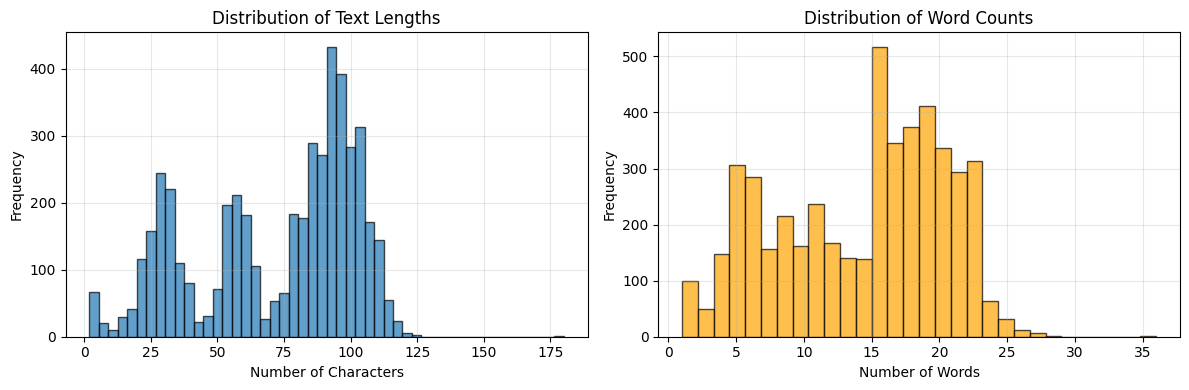


Sample Arabic texts:
1. في يام دولته من النصاره
2. غالبا لا صغيرة كبنت سبع سنين أو يائسة كبنت سبعين وقوله أو الاستحاضة من المسائل
3. ووجدهم قد احدقوا به ففضحهم واكشفهم عنه ولم يضروه بشىء فلما رجع وهب الى اهله قال


In [ ]:
# Analyze the text data
print("Text Analysis:")
print(f"Unique images in training: {train_df['image'].nunique()}")
print(f"Total characters in training texts: {train_df['text'].str.len().sum()}")
print(f"Average text length: {train_df['text'].str.len().mean():.2f} characters")
print(f"Min text length: {train_df['text'].str.len().min()}")
print(f"Max text length: {train_df['text'].str.len().max()}")

# Text length distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train_df['text'].str.len(), bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
word_counts = train_df['text'].str.split().str.len()
plt.hist(word_counts, bins=30, alpha=0.7, edgecolor='black', color='orange')
plt.title('Distribution of Word Counts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sample texts
print("\nSample Arabic texts:")
for i, text in enumerate(train_df['text'].head(3)):
    print(f"{i+1}. {text}")

Sample Training Images:


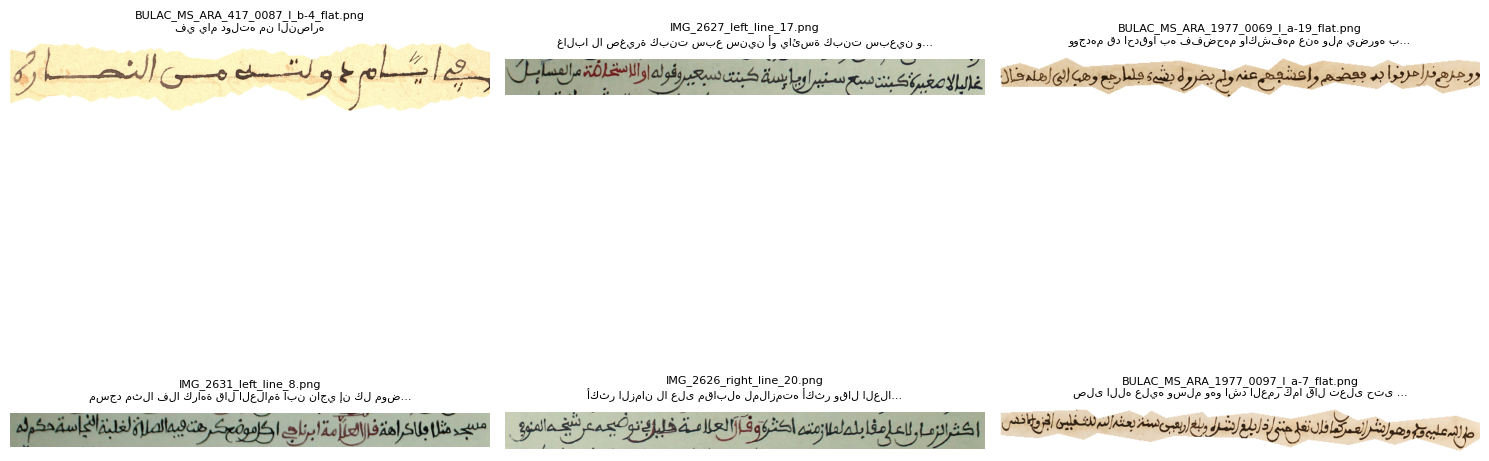

In [ ]:
# Explore images
def load_and_display_sample_images(df, folder_path, num_samples=6):
    """Load and display sample images with their corresponding texts"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(min(num_samples, len(df))):
        image_path = os.path.join(folder_path, df.iloc[i]['image'])

        if os.path.exists(image_path):
            # Load image
            img = cv2.imread(image_path)
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                axes[i].imshow(img_rgb)
                axes[i].axis('off')

                # Add text as title if available
                if 'text' in df.columns:
                    text = df.iloc[i]['text'][:50] + "..." if len(df.iloc[i]['text']) > 50 else df.iloc[i]['text']
                    axes[i].set_title(f"{df.iloc[i]['image']}\n{text}", fontsize=8, pad=10)
                else:
                    axes[i].set_title(df.iloc[i]['image'], fontsize=8, pad=10)
        else:
            axes[i].text(0.5, 0.5, f"Image not found:\n{df.iloc[i]['image']}",
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display sample training images
print("Sample Training Images:")
load_and_display_sample_images(train_df, 'train/train', 6)

Analyzing image properties...
Average image dimensions: 943.0 x 105.1
Average aspect ratio: 10.19


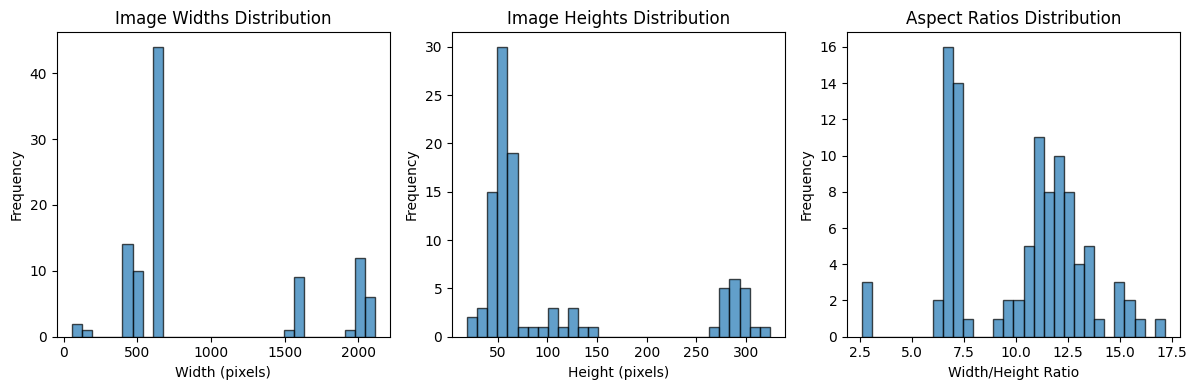

In [ ]:
# Image preprocessing functions for better OCR results
def preprocess_image(image_path, enhance=True):
    """
    Preprocess image for better OCR results
    """
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        return None

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if enhance:
        # Apply noise reduction
        denoised = cv2.fastNlMeansDenoising(gray)

        # Enhance contrast using CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(denoised)

        # Apply threshold to get binary image
        _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        return binary
    else:
        return gray

def analyze_image_properties(df, folder_path, sample_size=100):
    """Analyze properties of sample images"""
    heights, widths, channels = [], [], []

    sample_df = df.sample(min(sample_size, len(df)))

    for _, row in sample_df.iterrows():
        image_path = os.path.join(folder_path, row['image'])
        if os.path.exists(image_path):
            img = cv2.imread(image_path)
            if img is not None:
                h, w, c = img.shape
                heights.append(h)
                widths.append(w)
                channels.append(c)

    return {
        'heights': heights,
        'widths': widths,
        'channels': channels,
        'avg_height': np.mean(heights),
        'avg_width': np.mean(widths),
        'avg_aspect_ratio': np.mean(np.array(widths) / np.array(heights))
    }

# Analyze image properties
print("Analyzing image properties...")
img_props = analyze_image_properties(train_df, 'train/train')

print(f"Average image dimensions: {img_props['avg_width']:.1f} x {img_props['avg_height']:.1f}")
print(f"Average aspect ratio: {img_props['avg_aspect_ratio']:.2f}")

# Visualize image dimensions
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(img_props['widths'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Image Widths Distribution')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(img_props['heights'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Image Heights Distribution')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
aspect_ratios = np.array(img_props['widths']) / np.array(img_props['heights'])
plt.hist(aspect_ratios, bins=30, alpha=0.7, edgecolor='black')
plt.title('Aspect Ratios Distribution')
plt.xlabel('Width/Height Ratio')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Character Error Rate (CER) calculation
def calculate_cer(reference, predicted):
    """
    Calculate Character Error Rate (CER) between reference and predicted text
    CER = Edit Distance / Length of Reference Text
    """
    if len(reference) == 0:
        return 1.0 if len(predicted) > 0 else 0.0

    edit_distance = Levenshtein.distance(reference, predicted)
    cer = edit_distance / len(reference)
    return cer

def evaluate_predictions(true_texts, predicted_texts):
    """Evaluate predictions using CER metric"""
    if len(true_texts) != len(predicted_texts):
        raise ValueError("Number of true and predicted texts must be equal")

    cer_scores = []
    for true_text, pred_text in zip(true_texts, predicted_texts):
        cer = calculate_cer(true_text, pred_text)
        cer_scores.append(cer)

    average_cer = np.mean(cer_scores)

    return {
        'individual_cer': cer_scores,
        'average_cer': average_cer,
        'median_cer': np.median(cer_scores),
        'std_cer': np.std(cer_scores)
    }

# Test CER calculation
test_ref = "مرحبا بكم في التحدي"
test_pred = "مرحبا بكم في التحدي"
print(f"CER for identical texts: {calculate_cer(test_ref, test_pred)}")

test_pred_2 = "مرحبا بكم في التحدى"  # Small difference
print(f"CER for slightly different texts: {calculate_cer(test_ref, test_pred_2):.4f}")

CER for identical texts: 0.0
CER for slightly different texts: 0.0526


In [ ]:
# OCR Model Classes
class BaseOCRModel:
    """Base class for OCR models"""
    def __init__(self, name):
        self.name = name

    def predict(self, image_path):
        raise NotImplementedError

    def predict_batch(self, image_paths):
        predictions = []
        for img_path in image_paths:
            pred = self.predict(img_path)
            predictions.append(pred)
        return predictions

class EasyOCRModel(BaseOCRModel):
    """EasyOCR model for Arabic text recognition"""
    def __init__(self, preprocess_fn=None):
        super().__init__("EasyOCR")
        self.reader = easyocr.Reader(['ar'], gpu=True)  # Arabic language
        self.preprocess_fn = preprocess_fn
    def predict(self, image_path):
        try:
            # Preprocess image
            processed_img = preprocess_image(image_path, enhance=True)
            if processed_img is None:
                return ""

            # Perform OCR
            results = self.reader.readtext(processed_img)

            # Extract text
            text = ' '.join([result[1] for result in results])
            return text.strip()
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return ""

class TesseractOCRModel(BaseOCRModel):
    """Tesseract OCR model for Arabic text recognition"""
    def __init__(self,preprocess_fn=None):
        super().__init__("Tesseract")
        # Configure Tesseract for Arabic
        self.config = '--oem 3 --psm 6 -l ara'
        self.preprocess_fn = preprocess_fn

    def predict(self, image_path):
        try:
            # Preprocess image
            processed_img = preprocess_image(image_path, enhance=True)
            if processed_img is None:
                return ""

            # Perform OCR
            text = pytesseract.image_to_string(processed_img, config=self.config)
            return text.strip()
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return ""

# Test if models can be initialized
try:
    print("Initializing EasyOCR model...")
    easy_ocr = EasyOCRModel()
    print("✓ EasyOCR initialized successfully")
except Exception as e:
    print(f"✗ EasyOCR initialization failed: {e}")

try:
    print("Initializing Tesseract OCR model...")
    tesseract_ocr = TesseractOCRModel()
    print("✓ Tesseract OCR initialized successfully")
except Exception as e:
    print(f"✗ Tesseract OCR initialization failed: {e}")

Initializing EasyOCR model...
✓ EasyOCR initialized successfully
Initializing Tesseract OCR model...
✓ Tesseract OCR initialized successfully


In [ ]:
# Test OCR models on a small sample
def test_ocr_model(model, sample_df, folder_path, num_samples=5):
    """Test OCR model on a small sample and calculate CER"""
    print(f"\nTesting {model.name} on {num_samples} samples...")

    sample = sample_df.head(num_samples)
    predictions = []
    true_texts = []
    cer_scores = []

    for idx, row in sample.iterrows():
        image_path = os.path.join(folder_path, row['image'])

        if os.path.exists(image_path):
            # Get prediction
            pred_text = model.predict(image_path)
            true_text = row['text']

            # Calculate CER
            cer = calculate_cer(true_text, pred_text)

            predictions.append(pred_text)
            true_texts.append(true_text)
            cer_scores.append(cer)

            print(f"\nImage: {row['image']}")
            print(f"True:  {true_text}")
            print(f"Pred:  {pred_text}")
            print(f"CER:   {cer:.4f}")
        else:
            print(f"Image not found: {image_path}")

    if cer_scores:
        avg_cer = np.mean(cer_scores)
        print(f"\nAverage CER for {model.name}: {avg_cer:.4f}")
        return avg_cer, predictions, true_texts
    else:
        return None, [], []

# Create a small validation set
validation_sample = train_df.sample(n=10, random_state=42)
print("Selected validation samples:")
print(validation_sample[['image', 'text']].head())

Selected validation samples:
                                       image  \
4621  BULAC_MS_ARA_1977_0094_l_a-19_flat.png   
3992   BULAC_MS_ARA_1977_0072_l_a-8_flat.png   
794    BULAC_MS_ARA_1977_0033_l_a-1_flat.png   
1029  BULAC_MS_ARA_1977_0147_l_a-11_flat.png   
8     BULAC_MS_ARA_1977_0075_l_a-22_flat.png   

                                                   text  
4621  الكلام ولم برد طالب حاجة قط انا بنت حاتم طى فق...  
3992  واتى مسرعا فحدثته ءامنة بما رات وانه صلى الله ...  
794   الارض النور فركب عليها فطار بها فهو ارضى سماوي...  
1029  لحقناهم بكر بل افسالناهم لنزول على حكم عبد الل...  
8     وما وجدوه في الحجارة منقوشا بالخط الخديم فكان ...  


In [ ]:
# Ensemble approach for better results
class EnsembleOCRModel(BaseOCRModel):
    """Ensemble of multiple OCR models"""
    def __init__(self, models):
        super().__init__("Ensemble")
        self.models = models

    def predict(self, image_path):
        predictions = []
        for model in self.models:
            pred = model.predict(image_path)
            if pred:  # Only add non-empty predictions
                predictions.append(pred)

        if not predictions:
            return ""

        # Simple ensemble: return the longest prediction (often more complete)
        # You could also implement voting or other ensemble strategies
        return max(predictions, key=len)

def generate_predictions(model, test_df, test_folder, batch_size=50):
    """Generate predictions for test set"""
    print(f"Generating predictions using {model.name}...")

    predictions = []
    total_samples = len(test_df)

    for i in range(0, total_samples, batch_size):
        batch_end = min(i + batch_size, total_samples)
        batch_df = test_df.iloc[i:batch_end]

        batch_predictions = []
        for _, row in batch_df.iterrows():
            image_path = os.path.join(test_folder, row['image'])
            pred = model.predict(image_path)
            batch_predictions.append(pred)

        predictions.extend(batch_predictions)
        print(f"Processed {batch_end}/{total_samples} samples...")

    return predictions

def create_submission(test_df, predictions, filename='submission.csv'):
    """Create submission file"""
    submission_df = test_df.copy()
    submission_df['text'] = predictions

    # Ensure we maintain the original order
    submission_df = submission_df[['image', 'text']]
    submission_df.to_csv(filename, index=False)

    print(f"Submission saved to {filename}")
    print(f"Submission shape: {submission_df.shape}")
    print(f"Sample predictions:")
    print(submission_df.head())

    return submission_df

# Preprocessing pipeline
def preprocess_for_ocr(image_path):
    """Advanced preprocessing pipeline for Arabic manuscripts"""
    img = cv2.imread(image_path)
    if img is None:
        return None

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply multiple preprocessing techniques

    # 1. Noise reduction
    denoised = cv2.fastNlMeansDenoising(gray)

    # 2. Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced = clahe.apply(denoised)

    # 3. Morphological operations to connect broken characters
    kernel = np.ones((2,2), np.uint8)
    morphed = cv2.morphologyEx(enhanced, cv2.MORPH_CLOSE, kernel)

    # 4. Adaptive thresholding
    binary = cv2.adaptiveThreshold(morphed, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)

    return binary

print("Advanced preprocessing and ensemble methods ready!")

Advanced preprocessing and ensemble methods ready!


In [ ]:
# Install tesseract with Arabic language support
!apt-get install -y tesseract-ocr-ara

# Confirm installation
!ls /usr/share/tesseract-ocr/4.00/tessdata/ | grep ara


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-ara
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 645 kB of archives.
After this operation, 1,447 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-ara all 1:4.00~git30-7274cfa-1.1 [645 kB]
Fetched 645 kB in 1s (503 kB/s)
Selecting previously unselected package tesseract-ocr-ara.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-ara_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-ara (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-ara (1:4.00~git30-7274cfa-1.1) ...
ara.traineddata


In [ ]:
# === Submission Cell ===

# Step 1: Load test data
test_df = pd.read_csv("test_df.csv")  # Make sure test.csv is in your working directory
test_folder = "test/test"          # Adjust if your test images are elsewhere

# Step 2: Instantiate OCR models with custom preprocessing
easy_ocr = EasyOCRModel(preprocess_fn=preprocess_for_ocr)
tesseract_ocr = TesseractOCRModel(preprocess_fn=preprocess_for_ocr)

# Step 3: Build ensemble model
ensemble_model = EnsembleOCRModel([easy_ocr, tesseract_ocr])

# Step 4: Generate predictions
predictions = generate_predictions(ensemble_model, test_df, test_folder)

# Step 5: Handle empty/missing predictions
predictions = ["Missing" if (p is None or str(p).strip() == "") else p for p in predictions]
missing_count = sum([p == "Missing" for p in predictions])
print(f"Missing predictions (filled with 'Missing'): {missing_count}")

# Step 6: Create and save submission
submission_df = create_submission(test_df, predictions, filename="submission.csv")


Generating predictions using Ensemble...
Processed 50/1203 samples...
Processed 100/1203 samples...
Processed 150/1203 samples...
Processed 200/1203 samples...
Processed 250/1203 samples...
Processed 300/1203 samples...
Processed 350/1203 samples...
Processed 400/1203 samples...
Processed 450/1203 samples...
Processed 500/1203 samples...
Processed 550/1203 samples...


In [ ]:
# Fill missing predictions with an empty string
submission_df['text'] = submission_df['text'].fillna(' ')


# Save the CSV for submission
submission_df.to_csv('submission.csv', index=False)
print("Missing predictions after fill:", submission_df['text'].isna().sum())

Missing predictions after fill: 0


In [ ]:
# Replace empty strings with a single space if required
submission_df['text'] = submission_df['text'].replace('', ' ')
submission_df['text'] = submission_df['text'].astype(str)
submission_df['image'] = submission_df['image'].astype(str)
submission_df.to_csv('submission.csv', index=False)
